# **Bootstrapping: An Alternative to T-Test**

Bootstrapping is a resampling technique used in statistical analysis to estimate the sampling distribution of a statistic and make inferences about population parameters. It provides a flexible and data-driven approach, particularly **valuable when traditional assumptions for statistical tests are not fully met or when the sample size is small**.

Unlike traditional methods, bootstrapping is non-parametric and **does not rely on specific distributional assumptions**. By randomly sampling with replacement from the available data, it generates an empirical sampling distribution of the statistic of interest. This **enables estimation of variability, construction of confidence intervals, and hypothesis testing** without strict assumptions about the data distribution.

In this notebook, we will explore the concept of bootstrapping,  demonstrate its application in statistical analysis and compare it to a two-sample t-test. We will cover generating bootstrap samples, estimating confidence intervals, performing hypothesis tests, and interpreting results. By the end, you will have a solid understanding of bootstrapping and its benefits, empowering you to apply this technique confidently in your own data analysis.

### **Overview of when to use Bootstrapping:**
1. When the sample size is 30 or less and the population standard deviation is unknown.
1. Non-normal or unknown distribution
1. Outliers and skewness
1. When calculating the standard error for test-statistics is difficult.

### **``Loading and Visualizing the data``**

In [1]:
from scipy import stats as stat
from sklearn import datasets
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
iris_data = datasets.load_iris()

In [3]:
iris_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [4]:
target_dict = {0 : 'Setosa', 1 : "versicolor", 2 : "virginica"}

In [5]:
data = pd.DataFrame(data = iris_data.data, columns = iris_data.feature_names)
data['target'] = iris_data.target
data['target'] = data['target'].replace(target_dict)
data = data.drop(columns = ['sepal width (cm)', 'petal length (cm)', 'petal width (cm)'] )
data.head()

,sepal length (cm),target
0,5.1,Setosa
1,4.9,Setosa
2,4.7,Setosa
3,4.6,Setosa
4,5.0,Setosa


In [6]:
data.groupby('target').agg(['mean', 'median'])

sepal length (cm)       
                        mean median
target                             
Setosa                 5.006    5.0
versicolor             5.936    5.9
virginica              6.588    6.5

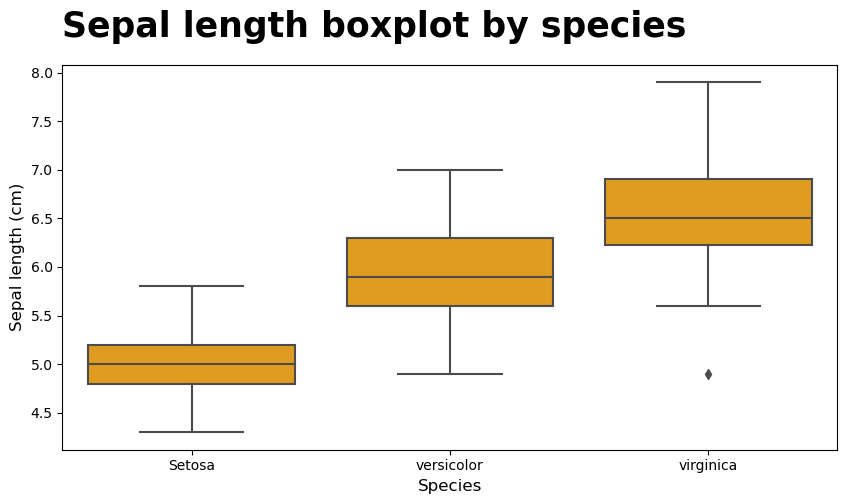

In [7]:
plt.figure(figsize=(10,5))

sns.boxplot(data = data,  x = 'target', y= 'sepal length (cm)', color = 'orange')

plt.title('Sepal length boxplot by species', size= 25, fontweight = 'bold', loc = 'left', pad = 20)
plt.ylabel('Sepal length (cm)', size= 12)
plt.xlabel('Species', size= 12)

plt.show()

In [8]:
# Separating the data
virginica = data[data['target'] == 'virginica']['sepal length (cm)']
versicolor = data[data['target'] == 'versicolor']['sepal length (cm)']

#### Defining function to plot t-distribution

In [9]:
# Creating function to plot the distribution of t-statistic
def plot_t_test(women, men, alternative='less', equal_var=True):
    # Perform independent t-test
    t_stat, p_value = stat.ttest_ind(women, men, alternative=alternative)

    # Plotting distribution of t-statistic
    degrees_freedom = women.count() + men.count() - 2
    alpha = 0.05  # significance level
    critical_value = stat.t.ppf(1 - alpha, degrees_freedom)  # calculate the critical value for t-stat

    x = np.linspace(-6, 6, 1000)  # x-axis values
    y = stat.t.pdf(x, degrees_freedom)  # corresponding y-axis values for a t-distribution with degrees of freedom (df)

    plt.figure(figsize=(15, 5))

    plt.plot(x, y, color='black', label='t-Distribution')

    # Add a vertical line representing the t-statistic and a text with its value
    plt.axvline(x=t_stat, color='red', linestyle='--', label='t-Statistic')
    plt.text(t_stat, stat.t.pdf(t_stat, degrees_freedom), f't = {t_stat:.2f}', size=20, color='black', verticalalignment='bottom', horizontalalignment='left')

    # Fill the rejection zone and the FTR zone based on alternative hypothesis
    if alternative == 'less':
        plt.fill_between(x, y, where=x < -critical_value, color='salmon', alpha=0.3, label='Rejection Zone')
        plt.fill_between(x, y, where=(x >= -critical_value), color='lightblue', alpha=0.3, label='FTR Zone')
    elif alternative == 'greater':
        plt.fill_between(x, y, where=x > critical_value, color='salmon', alpha=0.3, label='Rejection Zone')
        plt.fill_between(x, y, where=(x <= critical_value), color='lightblue', alpha=0.3, label='FTR Zone')
    elif alternative == 'two-sided':
        plt.fill_between(x, y, where=x < -critical_value, color='salmon', alpha=0.3, label='Rejection Zone')
        plt.fill_between(x, y, where=(x > critical_value), color='salmon', alpha=0.3)
        plt.fill_between(x, y, where=(x >= -critical_value) & (x <= critical_value), color='lightblue', alpha=0.3, label='FTR Zone')

    plt.title('Distribution of t-Statistic', size=20, fontweight='bold', loc='left', pad = 20)
    plt.xlabel('t', size=12)  # Replace with an appropriate label
    plt.ylabel('Probability Density', size=12)  # Replace with an appropriate label
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

### **``Two-sample t-test for difference in means``**

**Hypothesy:** Virginica sepal length (cm) mean is different than versicolor sepal length (cm) mean

- $H_0$: 𝜇<sub>virginica</sub> - 𝜇<sub>versicolor</sub> = 0
- $H_1$: 𝜇<sub>virginica</sub> - 𝜇<sub>versicolor</sub> ≠ 0

In [10]:
t_stat, p_value = stat.ttest_ind(virginica, versicolor, alternative='two-sided', equal_var=True)

# Print the test statistics and p-value
print('t Statistics:', t_stat)
print('p-value:', p_value)
print('p-value:', p_value/2)

t Statistics: 5.629165259719801
p-value: 1.7248563024547942e-07
p-value: 8.624281512273971e-08


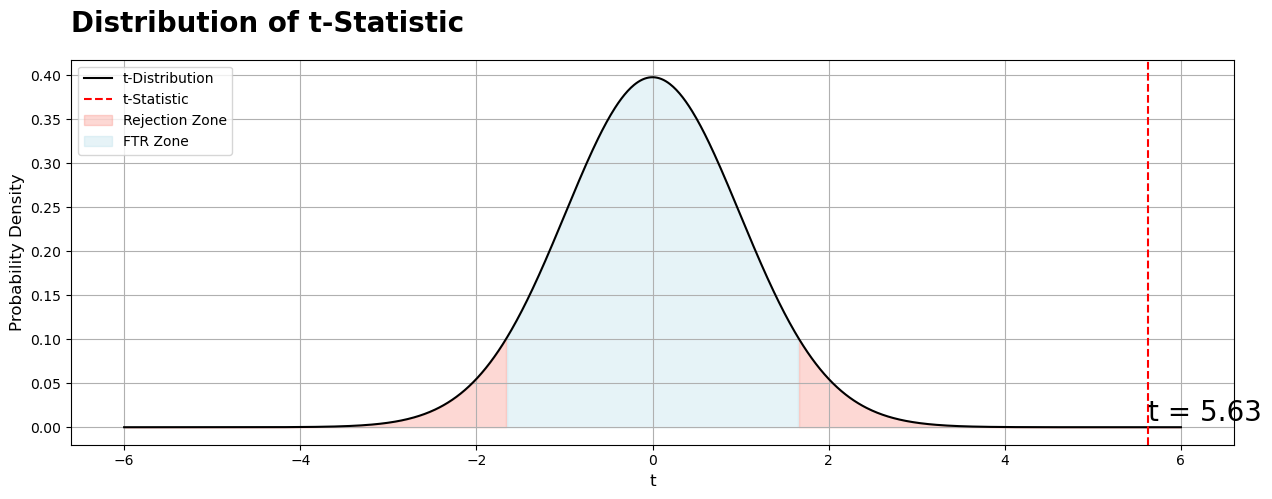

In [11]:
plot_t_test(virginica, versicolor, alternative='two-sided', equal_var=True)

**Result:** Reject $H_0$

**Interpretation:** Exist a significant difference between the mean sepal lenght (cm) between virginica and versicolor. This differente is positive, in other words, the mean of virginica is grater than the mean of versicolor.

### **``Bootstrap Hypothesis Test for difference in means``**

**Hypothesy:** Virginica sepal length (cm) mean is different than versicolor sepal length (cm) mean

- $H_0$: 𝜇<sub>virginica</sub> - 𝜇<sub>versicolor</sub> = 0
- $H_1$: 𝜇<sub>virginica</sub> - 𝜇<sub>versicolor</sub> ≠ 0

Before straing creating Bootstrapping samples, we first need to calculate the observed t-statistic: (𝜇<sub>virginica</sub> - 𝜇<sub>versicolor</sub>)

In [75]:
# Calculating 
observed_test_stat = virginica.mean() - versicolor.mean()
observed_test_stat

0.6519999999999984

Creating bootstrap samples and calculating the boot-test stat

In [76]:
# Number of bootstrap
n_bootstrap = 50000
# List of Bootstrap test-statistic
list_bootstrapped = []
# List of probability (bootstrap_test_stat >= oberseved_test_stat)
stat = []
# Sample bootstrap means from 1 & 2
sample_means = []
for _ in range(n_bootstrap):

    # Generate sample boostrap
    bootstrap_array = np.concatenate((virginica.values, versicolor.values)) # Concatenating two populations
    l = np.random.choice(a = bootstrap_array, size = len(bootstrap_array), replace = True)
    
    # Splitting the sample boostrap in the two population
    sample_1 = l[:len(virginica)]
    sample_2 = l[len(versicolor):]
    
    # Calculating Sample boostrap mean for both population
    mean_1 = np.array(sample_1).mean()
    mean_2 = np.array(sample_2).mean()
    
    # Appending the sample boostrap mean
    sample_means.append((mean_1, mean_2))
    
    # Calculate the boostrap test-statistic
    bott_test_stat = mean_1 - mean_2
    
    # Append the boostrap test-statistic
    list_bootstrapped.append(bott_test_stat)
      
    # Comparison
    stat.append(abs(bott_test_stat) >= abs(observed_test_stat))

##### **How to calculate p-value in Bootstrapping**

p-value = $\frac{{\text{{\# of times }} |bootstrap \, test \, stat| \geq |observed \, test \, stat|}}{B}$


**Explanation:**
The p-value formula in bootstrapping counts the number of times the bootstrap test statistic is greater than or equal to the observed test statistic. Dividing this count by the total number of bootstrap samples provides an estimate of the probability (p-value) of observing a test statistic as extreme as or more extreme than the observed test statistic under the null hypothesis. 

This calculation helps assess the significance of the observed test statistic by measuring the likelihood of obtaining such extreme results purely by chance.

**Calculating the p_value**

In [77]:
# The variable stat contains the comparison |bootstrap test stat| >= |observed test stat|
print(f'There are {np.array(stat).sum()} bootrstap t-stat that are greater or equal to the observed t-test')

There are 0 bootrstap t-stat that are greater or equal to the observed t-test


In [78]:
p_value = np.array(stat).sum() / n_bootstrap
p_value

0.0

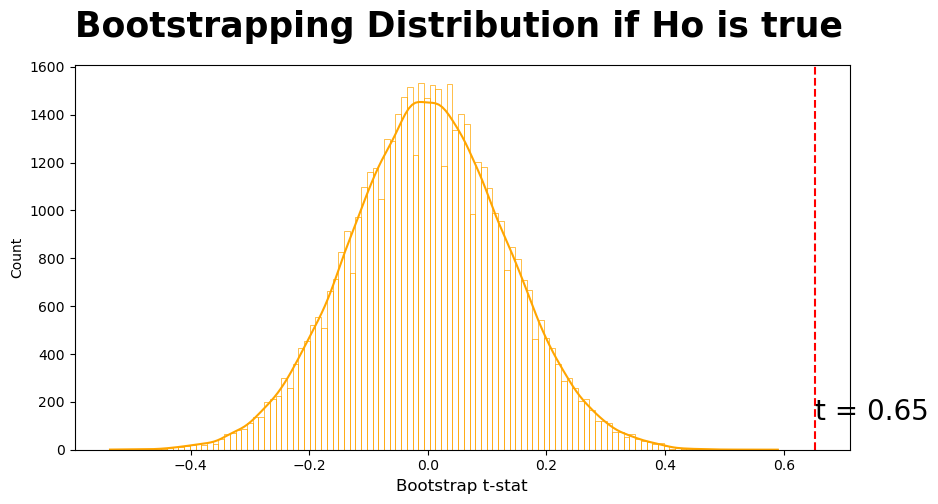

In [79]:
plt.figure(figsize=(10,5))

sns.histplot(x =list_bootstrapped, color= 'orange', fill = False, kde= True)

plt.title('Bootstrapping Distribution if Ho is true', size= 25, fontweight = 'bold', loc = 'left', pad = 20)
plt.xlabel('Bootstrap t-stat', size= 12)
plt.axvline(x=observed_test_stat, color='red', linestyle='--', label='t-Statistic')
plt.text(observed_test_stat, 100, f't = {observed_test_stat:.2f}', size=20, color='black', verticalalignment='bottom', horizontalalignment='left')

plt.show()

We got to the same result as the two-sample t-test. The p-value of the bootstrapping test was 0, indicating strong evidence that the means differ significantly.

**Result:** Reject $H_0$

**Interpretation:** Exist a significant difference between the mean sepal lenght (cm) between virginica and versicolor. This differente is positive, in other words, the mean of virginica is grater than the mean of versicolor.

### **``Bootstrap 95% Confidence Interval``**

Here we do not concatenate our two samples (virginica and versicolor)

In [96]:
# Generate a Booststrap sample and calculate the mean for it
def boot_strap_mean(data):
    shape = data.shape[0]
    data = data.values.reshape(-1)
    result = np.random.choice(data,size = shape, replace = True)
    return np.mean(result)

# Creating a function to calculate the difference between the means of virginica and versicolor bootstraps means
def main_boot(data1, data2):
    difference = [] # list to store the difference in means
    n_bootstrap_samples = 50000

    for i in range(n_bootstrap_samples):
        difference.append(boot_strap_mean(data1) - boot_strap_mean(data2)) # Using the boot_strap_mean to calculate the difference in means and append to the list

    difference = np.array(difference)
    
    return difference

In [97]:
difference = main_boot(virginica, versicolor)

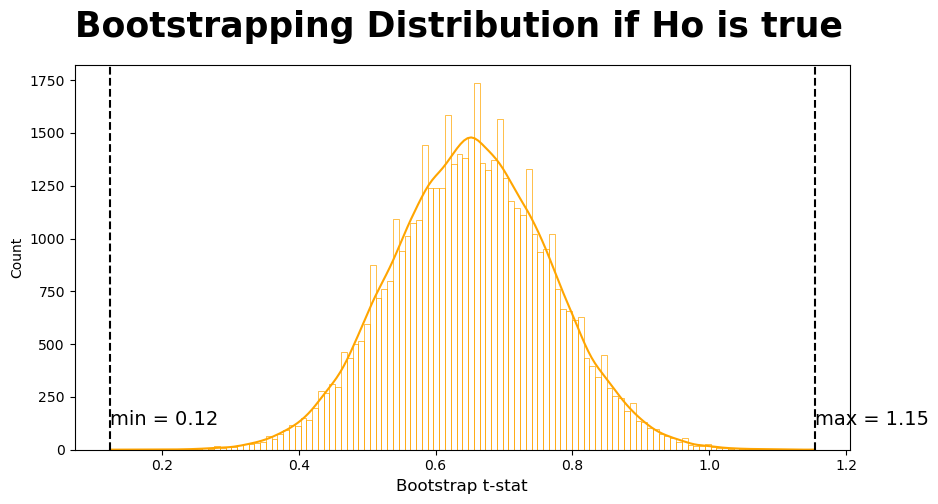

In [98]:
plt.figure(figsize=(10,5))

sns.histplot(x =difference, color= 'orange', fill = False, kde= True)

plt.title('Bootstrapping Distribution if Ho is true', size= 25, fontweight = 'bold', loc = 'left', pad = 20)
plt.xlabel('Bootstrap t-stat', size= 12)
plt.axvline(x=np.min(difference), color='black', linestyle='--', label='min_difference')
plt.text(np.min(difference), 100, f'min = {np.min(difference):.2f}', size=14, color='black', verticalalignment='bottom', horizontalalignment='left')
plt.axvline(x=np.max(difference), color='black', linestyle='--', label='max_difference')
plt.text(np.max(difference), 100, f'max = {np.max(difference):.2f}', size=14, color='black', verticalalignment='bottom', horizontalalignment='left')

plt.show()

To obtain the Confidence Interval for the difference in means, we can utilize the 2.5th and 97.5th percentiles to construct a 95% confidence interval.

In [99]:
lower_limit = np.percentile(difference, 2.5).round(4)
higher_limit = np.percentile(difference, 97.5).round(4)

print(f'We are 95% Confidence that the difference in means betwween virginica and versicolor lies within the interval: {lower_limit, higher_limit}')

We are 95% Confidence that the difference in means betwween virginica and versicolor lies within the interval: (0.428, 0.878)


### **Questions:**

#### **1. What is the difference between Hypothesis Testing and Building Confidence Interval?**

Hypothesis testing and building confidence intervals are two complementary approaches in statistical analysis that aim to draw conclusions about population parameters based on sample data. While they serve distinct purposes, they can lead to similar interpretations.

In hypothesis testing, we start with a null hypothesis (H0) that represents a specific claim or assumption about the population parameter. The goal is to assess the evidence against the null hypothesis and determine if it should be rejected in favor of an alternative hypothesis (H1). The focus of hypothesis testing is on evaluating the significance of the observed statistics and determining if they provide strong evidence against the null hypothesis.

On the other hand, building a confidence interval aims to estimate the range within which the true population parameter is likely to fall. It provides a range of plausible values based on the observed sample data. The confidence interval is centered around the observed statistics and reflects the uncertainty associated with the estimation.

While hypothesis testing focuses on evaluating the significance of the observed statistics against the null hypothesis, building a confidence interval centers around estimating the range of plausible values for the population parameter based on the observed data.

In summary, both hypothesis testing and building confidence intervals are important tools in statistical analysis. They provide different perspectives and serve different purposes, but they can lead to similar conclusions about the population parameter of interest.